# Generative Adversarial Nets

Training a generative adversarial network to sample from a Gaussian distribution. This is a toy problem, takes < 3 minutes to run on a modest 1.2GHz CPU.

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns # for pretty plots
from scipy.stats import norm
%matplotlib inline

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Target distribution $p_{data}$

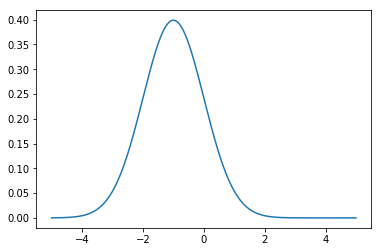

In [2]:
mu,sigma=-1,1
xs=np.linspace(-5,5,1000)
plt.plot(xs, norm.pdf(xs,loc=mu,scale=sigma))
#plt.savefig('fig0.png')

In [3]:
TRAIN_ITERS=10000
M=200 # minibatch size

In [4]:
# MLP - used for D_pre, D1, D2, G networks
def mlp(input, output_dim):
    # construct learnable parameters within local scope
    w1=tf.get_variable("w0", [input.get_shape()[1], 6], initializer=tf.random_normal_initializer())
    b1=tf.get_variable("b0", [6], initializer=tf.constant_initializer(0.0))
    w2=tf.get_variable("w1", [6, 5], initializer=tf.random_normal_initializer())
    b2=tf.get_variable("b1", [5], initializer=tf.constant_initializer(0.0))
    w3=tf.get_variable("w2", [5,output_dim], initializer=tf.random_normal_initializer())
    b3=tf.get_variable("b2", [output_dim], initializer=tf.constant_initializer(0.0))
    # nn operators
    fc1=tf.nn.tanh(tf.matmul(input,w1)+b1)
    fc2=tf.nn.tanh(tf.matmul(fc1,w2)+b2)
    fc3=tf.nn.tanh(tf.matmul(fc2,w3)+b3)
    return fc3, [w1,b1,w2,b2,w3,b3]

In [5]:
# re-used for optimizing all networks
def momentum_optimizer(loss,var_list):
    batch = tf.Variable(0)
    learning_rate = tf.train.exponential_decay(
        0.001,                # Base learning rate.
        batch,  # Current index into the dataset.
        TRAIN_ITERS // 4,          # Decay step - this decays 4 times throughout training process.
        0.95,                # Decay rate.
        staircase=True)
    #optimizer=tf.train.GradientDescentOptimizer(learning_rate).minimize(loss,global_step=batch,var_list=var_list)
    optimizer=tf.train.MomentumOptimizer(learning_rate,0.6).minimize(loss,global_step=batch,var_list=var_list)
    return optimizer

# Pre-train Decision Surface

If decider is reasonably accurate to start, we get much faster convergence.

In [6]:
with tf.variable_scope("D_pre"):
    input_node=tf.placeholder(tf.float32, shape=(M,1))
    train_labels=tf.placeholder(tf.float32,shape=(M,1))
    D,theta=mlp(input_node,1)
    loss=tf.reduce_mean(tf.square(D-train_labels))

In [7]:
optimizer=momentum_optimizer(loss,None)

In [8]:
sess=tf.InteractiveSession()
tf.global_variables_initializer().run()

In [9]:
# plot decision surface
def plot_d0(D,input_node):
    f,ax=plt.subplots(1)
    # p_data
    xs=np.linspace(-5,5,1000)
    ax.plot(xs, norm.pdf(xs,loc=mu,scale=sigma), label='p_data')
    # decision boundary
    r=1000 # resolution (number of points)
    xs=np.linspace(-5,5,r)
    ds=np.zeros((r,1)) # decision surface
    # process multiple points in parallel in a minibatch
    for i in range(r//M):
        x=np.reshape(xs[M*i:M*(i+1)],(M,1))
        ds[M*i:M*(i+1)]=sess.run(D,{input_node: x})

    ax.plot(xs, ds, label='decision boundary')
    ax.set_ylim(0,1.1)
    plt.legend()

Text(0.5,1,'Initial Decision Boundary')

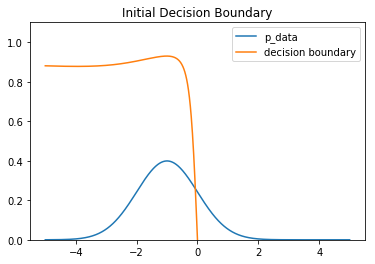

In [10]:
plot_d0(D,input_node)
plt.title('Initial Decision Boundary')
#plt.savefig('fig1.png')

In [11]:
lh=np.zeros(1000)
for i in range(1000):
    #d=np.random.normal(mu,sigma,M)
    d=(np.random.random(M)-0.5) * 10.0 # instead of sampling only from gaussian, want the domain to be covered as uniformly as possible
    labels=norm.pdf(d,loc=mu,scale=sigma)
    lh[i],_=sess.run([loss,optimizer], {input_node: np.reshape(d,(M,1)), train_labels: np.reshape(labels,(M,1))})

Text(0.5,1,'Training Loss')

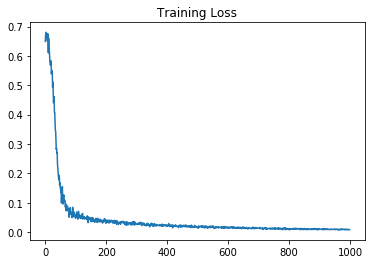

In [12]:
# training loss
plt.plot(lh)
plt.title('Training Loss')

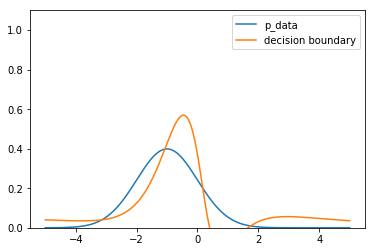

In [13]:
plot_d0(D,input_node)
#plt.savefig('fig2.png')

In [14]:
# copy the learned weights over into a tmp array
weightsD=sess.run(theta)

In [15]:
# close the pre-training session
sess.close()

# Build Net

Now to build the actual generative adversarial network

In [16]:
with tf.variable_scope("G"):
    z_node=tf.placeholder(tf.float32, shape=(M,1)) # M uniform01 floats
    G,theta_g=mlp(z_node,1) # generate normal transformation of Z
    G=tf.multiply(5.0,G) # scale up by 5 to match range
with tf.variable_scope("D") as scope:
    # D(x)
    x_node=tf.placeholder(tf.float32, shape=(M,1)) # input M normally distributed floats
    fc,theta_d=mlp(x_node,1) # output likelihood of being normally distributed
    D1=tf.maximum(tf.minimum(fc,.99), 0.01) # clamp as a probability
    # make a copy of D that uses the same variables, but takes in G as input
    scope.reuse_variables()
    fc,theta_d=mlp(G,1)
    D2=tf.maximum(tf.minimum(fc,.99), 0.01)
obj_d=tf.reduce_mean(tf.log(D1)+tf.log(1-D2))
obj_g=tf.reduce_mean(tf.log(D2))

# set up optimizer for G,D
opt_d=momentum_optimizer(1-obj_d, theta_d)
opt_g=momentum_optimizer(1-obj_g, theta_g) # maximize log(D(G(z)))

In [17]:
sess=tf.InteractiveSession()
tf.global_variables_initializer().run()

In [18]:
# copy weights from pre-training over to new D network
for i,v in enumerate(theta_d):
    sess.run(v.assign(weightsD[i]))

In [19]:
def plot_fig():
    # plots pg, pdata, decision boundary 
    f,ax=plt.subplots(1)
    # p_data
    xs=np.linspace(-5,5,1000)
    ax.plot(xs, norm.pdf(xs,loc=mu,scale=sigma), label='p_data')

    # decision boundary
    r=5000 # resolution (number of points)
    xs=np.linspace(-5,5,r)
    ds=np.zeros((r,1)) # decision surface
    # process multiple points in parallel in same minibatch
    for i in range(r//M):
        x=np.reshape(xs[M*i:M*(i+1)],(M,1))
        ds[M*i:M*(i+1)]=sess.run(D1,{x_node: x})

    ax.plot(xs, ds, label='decision boundary')

    # distribution of inverse-mapped points
    zs=np.linspace(-5,5,r)
    gs=np.zeros((r,1)) # generator function
    for i in range(r//M):
        z=np.reshape(zs[M*i:M*(i+1)],(M,1))
        gs[M*i:M*(i+1)]=sess.run(G,{z_node: z})
    histc, edges = np.histogram(gs, bins = 10)
    ax.plot(np.linspace(-5,5,10), histc/float(r), label='p_g')

    # ylim, legend
    ax.set_ylim(0,1.1)
    plt.legend()

Text(0.5,1,'Before Training')

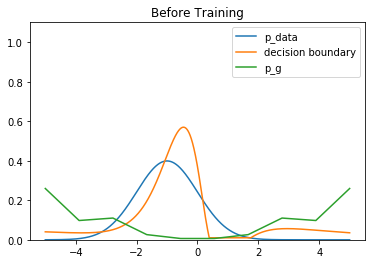

In [20]:
# initial conditions
plot_fig()
plt.title('Before Training')
#plt.savefig('fig3.png')

In [21]:
# Algorithm 1 of Goodfellow et al 2014
k=1
histd, histg= np.zeros(TRAIN_ITERS), np.zeros(TRAIN_ITERS)
for i in range(TRAIN_ITERS):
    for j in range(k):
        x= np.random.normal(mu,sigma,M) # sampled m-batch from p_data
        x.sort()
        z= np.linspace(-5.0,5.0,M)+np.random.random(M)*0.01  # sample m-batch from noise prior
        histd[i],_=sess.run([obj_d,opt_d], {x_node: np.reshape(x,(M,1)), z_node: np.reshape(z,(M,1))})
    z= np.linspace(-5.0,5.0,M)+np.random.random(M)*0.01 # sample noise prior
    histg[i],_=sess.run([obj_g,opt_g], {z_node: np.reshape(z,(M,1))}) # update generator
    if i % (TRAIN_ITERS//10) == 0:
        print(float(i)/float(TRAIN_ITERS))

0.0
0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9


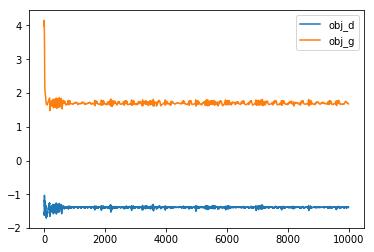

In [22]:
plt.plot(range(TRAIN_ITERS),histd, label='obj_d')
plt.plot(range(TRAIN_ITERS), 1-histg, label='obj_g')
plt.legend()
#plt.savefig('fig4.png')

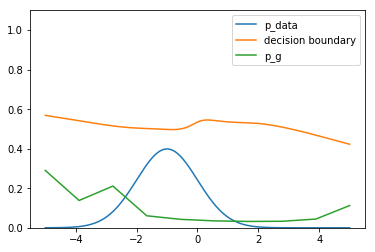

In [23]:
plot_fig()
#plt.savefig('fig5.png')